In [1]:
import pandas as pd

# 加载数据
df = pd.read_csv('merged.csv', parse_dates=['decision_date', 'sentiment_date'])

# 查看前几行数据
print(df.head())


  decision_date  rate_change   decision sentiment_date  sentiment  \
0    1996-11-13         0.00  No Change     1996-10-30   0.028881   
1    1996-12-17         0.00  No Change     1996-12-04  -0.588398   
2    1997-02-05         0.00  No Change     1997-01-22   0.123663   
3    1997-03-25         0.25   Increase     1997-03-12  -0.728463   
4    1997-05-20         0.00  No Change     1997-05-07  -0.035630   

                                      sentiment_dict  days_difference  
0  {'positive': 0.1624157875776291, 'negative': 0...               14  
1  {'positive': 0.07799529284238815, 'negative': ...               13  
2  {'positive': 0.17666494846343994, 'negative': ...               14  
3  {'positive': 0.02856595441699028, 'negative': ...               13  
4  {'positive': 0.16252721846103668, 'negative': ...               13  


/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 检查缺失值
print(df.isnull().sum())



decision_date      0
rate_change        0
decision           0
sentiment_date     0
sentiment          0
sentiment_dict     0
days_difference    0
dtype: int64


In [3]:
from sklearn.preprocessing import LabelEncoder

# 创建 LabelEncoder 实例
le = LabelEncoder()

# 对 'decision' 列进行编码
df['decision_encoded'] = le.fit_transform(df['decision'])

# 显示编码后的映射关系
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label Mapping:', label_mapping)


Label Mapping: {'Decrease': 0, 'Increase': 1, 'No Change': 2}


In [4]:
# 如果还没有 'sentiment_lag1'，创建它
df.sort_values('sentiment_date', inplace=True)
df['sentiment_lag1'] = df['sentiment'].shift(1)
df['sentiment_lag2'] = df['sentiment'].shift(2)

# 删除因滞后产生的缺失值
df.dropna(subset=['sentiment_lag1', 'sentiment_lag2'], inplace=True)

# 定义特征和目标变量
features = ['sentiment', 'sentiment_lag1', 'sentiment_lag2']
X = df[features]
y = df['decision_encoded']


In [5]:
# 划分训练集和测试集
# 按时间顺序划分数据
split_ratio = 0.8  # 80% 用于训练，20% 用于测试
split_index = int(len(df) * split_ratio)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# 检查数据集大小
print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)


Training set size: (164, 3)
Test set size: (41, 3)


逻辑回归模型

In [6]:
# 逻辑回归模型
from sklearn.linear_model import LogisticRegression

# 创建逻辑回归模型实例
logreg_model = LogisticRegression(max_iter=1000)

# 训练模型
logreg_model.fit(X_train, y_train)



LogisticRegression(max_iter=1000)

决策树模型

In [7]:
from sklearn.tree import DecisionTreeClassifier

# 创建决策树模型实例
dt_model = DecisionTreeClassifier(random_state=42)

# 训练模型
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

随机森林模型

In [8]:
from sklearn.ensemble import RandomForestClassifier

# 创建随机森林模型实例
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
# 定义评估函数
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # 生成分类报告
    print(f"=== {model_name} Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00         6
    Increase       0.00      0.00      0.00        11
   No Change       0.57      0.96      0.72        24

    accuracy                           0.56        41
   macro avg       0.19      0.32      0.24        41
weighted avg       0.34      0.56      0.42        41



/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


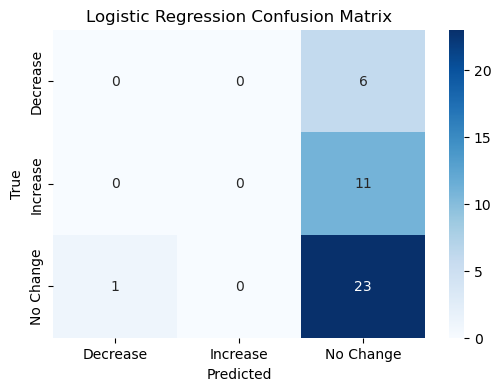

In [11]:
# 评估逻辑回归模型
evaluate_model(logreg_model, X_test, y_test, 'Logistic Regression')


=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00         6
    Increase       0.29      0.18      0.22        11
   No Change       0.50      0.54      0.52        24

    accuracy                           0.37        41
   macro avg       0.26      0.24      0.25        41
weighted avg       0.37      0.37      0.36        41



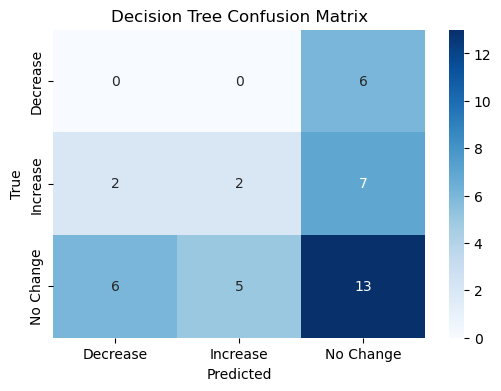

In [12]:
# 评估决策树模型
evaluate_model(dt_model, X_test, y_test, 'Decision Tree')


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00         6
    Increase       0.29      0.18      0.22        11
   No Change       0.53      0.71      0.61        24

    accuracy                           0.46        41
   macro avg       0.27      0.30      0.28        41
weighted avg       0.39      0.46      0.42        41



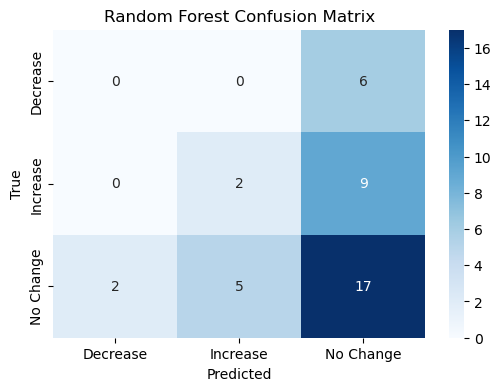

In [13]:
# 评估随机森林模型
evaluate_model(rf_model, X_test, y_test, 'Random Forest')



=== Support Vector Machine Classification Report ===
              precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00         6
    Increase       0.00      0.00      0.00        11
   No Change       0.57      0.96      0.72        24

    accuracy                           0.56        41
   macro avg       0.19      0.32      0.24        41
weighted avg       0.34      0.56      0.42        41



/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


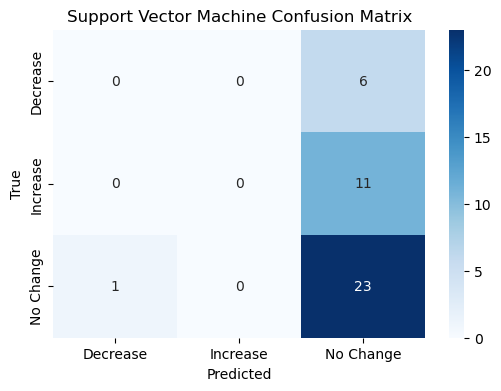

In [14]:
# 支持向量机（SVM）
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)
evaluate_model(svm_model, X_test, y_test, 'Support Vector Machine')


使用 XGBoost 进行训练

In [17]:
import xgboost as xgb
from sklearn.metrics import classification_report

# 将数据转换为 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置参数
params = {
    'objective': 'multi:softmax',
    'num_class': y.nunique(),
    'eval_metric': 'mlogloss',
    'seed': 42
}

# 训练模型
bst = xgb.train(params, dtrain, num_boost_round=100)

# 预测
y_pred = bst.predict(dtest)

# 评估
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00         6
    Increase       0.43      0.27      0.33        11
   No Change       0.56      0.75      0.64        24

    accuracy                           0.51        41
   macro avg       0.33      0.34      0.33        41
weighted avg       0.44      0.51      0.47        41



XGBoost 参数调优示例

In [19]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# 定义参数网格
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# 使用时间序列拆分
tscv = TimeSeriesSplit(n_splits=5)

# 创建 XGBoost 分类模型
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 使用随机搜索进行调优
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid_xgb,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 进行超参数调优
random_search_xgb.fit(X_train, y_train)

# 输出最佳参数
print("XGBoost 最佳参数：", random_search_xgb.best_params_)

# 使用最佳模型进行预测
best_xgb_clf = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_clf.predict(X_test)

# 评估模型
print("=== XGBoost 调优后分类模型评估 ===")
print(classification_report(y_test, y_pred_best_xgb, target_names=le.classes_))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas re

XGBoost 最佳参数： {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
=== XGBoost 调优后分类模型评估 ===
              precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00         6
    Increase       0.40      0.18      0.25        11
   No Change       0.58      0.88      0.70        24

    accuracy                           0.56        41
   macro avg       0.33      0.35      0.32        41
weighted avg       0.45      0.56      0.48        41



/Users/wooxoo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use